In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sympy as sy
import json
import pickle
from numpy.linalg import norm

from time import time
from numpy import cos, sin
from tqdm import tqdm

from scipy.integrate import odeint, quad, solve_ivp
from scipy.special import lpmn, lpmv, jv, jnyn_zeros, j0, j1
from scipy.stats import rv_continuous

In [2]:
R_earth = 6400000
R_moon = 1737100
dist_moon = 380000000
R_m = 16 * R_earth
b = 5 * R_earth
phi_ecl = np.pi / 36
cos_ecl = cos(phi_ecl)
sin_ecl = sin(phi_ecl)
g_10 = -29404.8 * 1e-9
g_11 = -1450.9 * 1e-9
h_11 = 4652.5 * 1e-9 
k_b = 1.38e-23
q = 1.6e-19 #Кл
m = 1.67e-27 #Кг
c = 3e8 #м/с
mu_0 = 4*np.pi * 1e-7 # Гн/м
m_x = 4*np.pi*R_earth**3 / mu_0 * g_11
m_y = 4*np.pi*R_earth**3 / mu_0 * h_11
m_z = 4*np.pi*R_earth**3 / mu_0 * g_10

In [24]:
class MagnetField:

    def __init__(self, N=10):

        self.N = N
        self.ns = np.arange(1, N+1)
        self.a_0, self.a_1, self.x_0, self.x_1 = self.create_const_a(N=N)
        self.R_m_arr = np.array([R_m]*N)
        self.m_x_arr = np.array([m_x]*N)
        self.m_y_arr = np.array([m_y]*N)
        self.m_z_arr = np.array([m_z]*N)
        self.mu_0_arr = np.array([mu_0]*N)
        
    def create_start_points_for_particles(self, r_nums=1, thetha_nums=2, phi_nums=4,
                                          thetha_v_nums=3, phi_v_nums=3, v_nums=3, m_particles=16*m):
        
        thetha_np = thetha_north_pole(name='thetha_norht_pole', a=np.pi/3, b=7*np.pi/18)
        phi_np = phi_north_pole(name='phi_north_pole', a=np.pi/36, b=11*np.pi/180)
        thetha_sp = thetha_south_pole(name='thetha_south_pole', a=23*np.pi/36, b=25*np.pi/36)
        phi_sp = phi_south_pole(name='phi_north_pole', a=0, b=np.pi/18)
        r_dist = R_dist(name='R_dist', a=6*R_earth, b=10*R_earth)
        v_t = v_thetha(name='v_thetha', a=0, b=2*np.pi)
        v_p = v_phi(name='v_phi', a=0, b=2*np.pi)
        w_dist = W_dist(name='R_dist', a=1e3, b=1e4)
        
        
        theta = np.concatenate((thetha_np.rvs(size=thetha_nums),
                                thetha_sp.rvs(size=thetha_nums)))
        phi = np.concatenate((phi_np.rvs(size=phi_nums),
                              phi_sp.rvs(size=phi_nums)))
        r = r_dist.rvs(size=r_nums)
        theta_v = v_t.rvs(size=thetha_v_nums)
        phi_v = v_p.rvs(size=phi_v_nums)
        v = w2v(w_dist.rvs(size=v_nums), m_particles=m_particles)

        return theta, phi, r, theta_v, phi_v, v
    
    @staticmethod
    def w2v(w, m_particles=16*m):
            return c*np.sqrt(1-1/(1+(w*q)/(m_particles*c**2))**2)

    @staticmethod
    def make_start_points_for_magnetosphere(thetha_nums=10, phi_nums=10):
        theta = np.linspace(0, np.pi, num=thetha_nums)
        phi = np.linspace(0, 2 * np.pi, num=phi_nums)
        r = np.linspace(R_earth, R_earth, num=1)

        th, ph, rr = np.meshgrid(theta, phi, r)

        th = np.expand_dims(th, axis=-1)
        ph = np.expand_dims(ph, axis=-1)
        rr = np.expand_dims(rr, axis=-1)

        start_points = np.concatenate((rr, th, ph), axis=-1)
        start_points = start_points.reshape(-1, 3)
        return start_points

    @staticmethod
    def create_const_a(N=100):
        jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(0, 10)
        x_0 = jnp_roots
        jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(1, 10)
        x_1 = jnp_roots

        def f0(x):
            S = -b / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += -1 / b ** 2 * (n + 1) * (-b / R_m) ** (n + 1) * (x / R_m) ** n * lpmv(0, n, 0)
            return S

        def f1(x):
            S = x / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += 1 / b ** 2 * (n + 1) / n * (-b / R_m) ** (n + 1) * (x / R_m) ** n * (-lpmv(1, n, 0))
            return S

        def func(x, x_nn, v):
            if v == 0:
                return x * jv(0, x_nn * x / R_m) * f0(x)
            else:
                return x * jv(1, x_nn * x / R_m) * f1(x)

        a_0 = np.array([2 / (R_m ** 2 * jv(0, x_0[n]) ** 2) * quad(func, 0, R_m, args=(x_0[n], 0))[0] for n in
                        tqdm(range(N), desc="Подсчет a_0")])
        a_1 = np.array(
            [2 / (R_m ** 2 * jv(1, x_1[n]) ** 2 * (1 - (1 / x_1[n]) ** 2)) * quad(func, 0, R_m, args=(x_1[n], 1))[0] for
             n in tqdm(range(N), desc="Подсчет a_1")])
        return a_0, a_1, x_0, x_1

    @staticmethod
    def legs(theta):

        cos_theta = cos(theta)
        sin_theta = sin(theta)

        legs_0n = np.array([cos_theta, 1 / 2 * (3 * cos_theta ** 2 - 1),
                            1 / 2 * (5 * cos_theta ** 3 - 3 * cos_theta),
                            1 / 8 * (35 * cos_theta ** 4 - 30 * cos_theta ** 2 + 3),
                            1 / 8 * (63 * cos_theta ** 5 - 70 * cos_theta ** 3 + 15 * cos_theta),
                            1 / 16 * (231 * cos_theta ** 6 - 315 * cos_theta ** 4 + 105 * cos_theta ** 2 - 5),
                            1 / 16 * (
                                        429 * cos_theta ** 7 - 693 * cos_theta ** 5 + 315 * cos_theta ** 3 - 35 * cos_theta),
                            1 / 128 * (
                                        6435 * cos_theta ** 8 - 12012 * cos_theta ** 6 + 6930 * cos_theta ** 4 - 1260 * cos_theta ** 2 + 35),
                            1 / 128 * (
                                        12155 * cos_theta ** 9 - 25740 * cos_theta ** 7 + 18018 * cos_theta ** 5 - 4620 * cos_theta ** 3 + 315 * cos_theta),
                            1 / 256 * (
                                        46189 * cos_theta ** 10 - 109395 * cos_theta ** 8 + 90090 * cos_theta ** 6 - 30030 * cos_theta ** 4 + 3465 * cos_theta ** 2 - 63)]
                           )
        legs_1n = np.array([np.abs(sin_theta), 3 * cos_theta * np.abs(sin_theta),
                            3 / 2 * np.abs(sin_theta) * (5 * cos_theta ** 2 - 1),
                            5 / 2 * np.abs(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                            15 / 8 * np.abs(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                            21 / 8 * np.abs(sin_theta) * (33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                            7 / 16 * np.abs(sin_theta) * (
                                        429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                            9 / 16 * np.abs(sin_theta) * (
                                        715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                            45 / 128 * np.abs(sin_theta) * (
                                        2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                            55 / 128 * np.abs(sin_theta) * (
                                        4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                           )
        divlegs_0n = np.array([-sin_theta, -3 * sin_theta * cos_theta,
                               -3 / 2 * sin_theta * (5 * cos_theta ** 2 - 1),
                               -5 / 2 * sin_theta * cos_theta * (7 * cos_theta ** 2 - 3),
                               -15 / 8 * sin_theta * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                               -21 / 8 * sin_theta * cos_theta * (33 * cos_theta ** 4 - 30 * cos_theta ** 2 + 5),
                               -7 / 16 * sin_theta * (
                                           429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                               -9 / 16 * sin_theta * cos_theta * (
                                           715 * cos_theta ** 6 - 1001 * cos_theta ** 4 + 385 * cos_theta ** 2 - 35),
                               -45 / 128 * sin_theta * (
                                           2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                               -55 / 128 * sin_theta * cos_theta * (
                                           4199 * cos_theta ** 8 - 7956 * cos_theta ** 6 + 4914 * cos_theta ** 4 - 1092 * cos_theta ** 2 + 63)]
                              )
        divlegs_1n = np.array([cos_theta * np.sign(sin_theta), -3 * np.sign(sin_theta) * (1 - 2 * cos_theta ** 2),
                               -3 / 2 * np.sign(sin_theta) * cos_theta * (11 - 15 * cos_theta ** 2),
                               5 / 2 * np.sign(sin_theta) * (28 * cos_theta ** 4 - 27 * cos_theta ** 2 + 3),
                               15 / 8 * np.sign(sin_theta) * cos_theta * (
                                           105 * cos_theta ** 4 - 126 * cos_theta ** 2 + 29),
                               21 / 8 * np.sign(sin_theta) * (
                                           198 * cos_theta ** 6 - 285 * cos_theta ** 4 + 100 * cos_theta ** 2 - 5),
                               7 / 16 * np.sign(sin_theta) * cos_theta * (
                                           3003 * cos_theta ** 6 - 5049 * cos_theta ** 4 + 2385 * cos_theta ** 2 - 275),
                               9 / 16 * np.sign(sin_theta) * (
                                           5720 * cos_theta ** 8 - 11011 * cos_theta ** 6 + 6545 * cos_theta ** 4 - 1225 * cos_theta ** 2 + 35),
                               45 / 128 * np.sign(sin_theta) * cos_theta * (
                                           21879 * cos_theta ** 8 - 47476 * cos_theta ** 6 + 34034 * cos_theta ** 4 - 8932 * cos_theta ** 2 + 623),
                               55 / 128 * np.sign(sin_theta) * (
                                           41990 * cos_theta ** 10 - 101439 * cos_theta ** 8 + 85176 * cos_theta ** 6 - 28938 * cos_theta ** 4 + 3402 * cos_theta ** 2 - 63)]
                              )
        legs_1n_div_sin = np.array([np.sign(sin_theta), 3 * cos_theta * np.sign(sin_theta),
                                    3 / 2 * np.sign(sin_theta) * (5 * cos_theta ** 2 - 1),
                                    5 / 2 * np.sign(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                                    15 / 8 * np.sign(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                                    21 / 8 * np.sign(sin_theta) * (
                                                33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                                    7 / 16 * np.sign(sin_theta) * (
                                                429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                                    9 / 16 * np.sign(sin_theta) * (
                                                715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                                    45 / 128 * np.sign(sin_theta) * (
                                                2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                                    55 / 128 * np.sign(sin_theta) * (
                                                4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                                   )

        return legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin

    def fast_legs(self, theta):
        ([legs_0n, legs_1n], [divlegs_0n, divlegs_1n]) = lpmn(1, 10, cos(theta))
        return legs_0n[1:], -legs_1n[1:], (-divlegs_0n * sin(theta))[1:], (divlegs_1n * sin(theta))[1:], -legs_1n[1:] / sin(theta)

    def choose_legs(self, theta, eps=1e-5):
        if theta < eps:
            return self.legs(theta)
        return self.fast_legs(theta)

    def sphere_to_decart(self, point, B):
        r, theta, phi = point
        C = np.array([[sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)],
                      [cos(theta) * cos(phi), cos(theta) * sin(phi), -sin(theta)],
                      [-sin(phi), cos(phi), 0]])
        B_xyz = B @ C
        point_xyz = np.array([r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)])
        return B_xyz, point_xyz

    def decart_to_sphere(self, x, y, z, eps=1e-8):
        r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        theta = np.arccos(z / r)
        phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
        return np.array([r, theta, phi])

    def spher_to_cyl(self, point):
        r, theta, phi = point

        rho = r * sin(theta)
        phi = phi
        z = r * cos(theta)

        return rho, phi, z
    
    def conf_B_tail(self, point, lambd):
        rho, phi, z = self.spher_to_cyl(point)

        jv_1x_0 = j1(self.x_0[:self.N] * rho / R_m)
        jv_1x_1 = j1(self.x_1[:self.N] * rho / R_m)
        jv_0x_1 = j0(self.x_1[:self.N] * rho / R_m)
        jv_0x_0 = j0(self.x_0[:self.N] * rho / R_m)
        jv_2x_1 = jv(2, self.x_1[:self.N] * rho / R_m)

        cos_phi = np.array([cos(phi)]*self.N)
        sin_phi = np.array([sin(phi)]*self.N)
        expx_1 = np.exp(-self.x_1[:self.N] * z / R_m)
        expx_0 = np.exp(-self.x_0[:self.N] * z / R_m)
        explambdx_1 = np.exp(-lambd * self.x_1[:self.N] * z / R_m)
        explambdx_0 = np.exp(-lambd * self.x_0[:self.N] * z / R_m)
        mu_0_arr = np.array([mu_0/(4*np.pi)]*self.N)

        res = np.sum([mu_0_arr / self.R_m_arr * (
                     (self.x_0 * self.a_0 * self.m_x_arr  * jv_1x_0 * (expx_0 + lambd*explambdx_0)
                      + 0.5 * self.x_1 * self.a_1 * (self.m_z_arr * cos_phi + self.m_y_arr * sin_phi)* (jv_2x_1 - jv_0x_1) * (expx_1 + lambd*explambdx_1)
                                                 )
                       ),
                     self.a_1 * mu_0_arr / rho * (
                         (self.m_z_arr * sin_phi - self.m_y_arr * cos_phi)* jv_1x_1 * (expx_1 + lambd * explambdx_1)
                       ),
                      mu_0_arr / self.R_m_arr * (
                          self.x_0  * self.a_0 * self.m_x_arr * jv_0x_0 * (expx_0 + explambdx_0)
                          + self.x_1 * self.a_1 * (self.m_z_arr * cos_phi + self.m_y_arr * sin_phi) * jv_1x_1 * (expx_1 + explambdx_1)
                                             )
                       ], axis=1) / 2
        return res

    def cyl_to_dec(self, point, B):
        rho, phi, z = self.spher_to_cyl(point)
        C = np.array([[cos(phi), -sin(phi), 0],
                      [sin(phi), cos(phi), 0],
                      [0, 0, 1]])
        B_xyz = C @ B
        point_xyz = np.array([rho * cos(phi), rho * sin(phi), z])
        return B_xyz, point_xyz

    def conf_B_sphere_cfa(self, point, B_imf_xyz):
        r, theta, phi = point

        legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = self.choose_legs(theta)
        B_cfa_r = - (R_m / r) ** 3 * (
                    B_imf_xyz[2] * legs_0n[0] + B_imf_xyz[0] * cos(phi) * legs_1n[0] + B_imf_xyz[1] * sin(phi) *
                    legs_1n[0])
        B_cfa_theta = 0.5 * (R_m / r) ** 3 * (
                    B_imf_xyz[2] * divlegs_0n[0] + B_imf_xyz[0] * cos(phi) * divlegs_1n[0] + B_imf_xyz[1] * sin(phi) *
                    divlegs_1n[0])
        B_cfa_phi = 0.5 * (R_m / r) ** 3 * (
                    -B_imf_xyz[0] * sin(phi) * legs_1n_div_sin[0] + B_imf_xyz[1] * cos(phi) * legs_1n_div_sin[0])
        return np.array([B_cfa_r, B_cfa_theta, B_cfa_phi])

    def conf_B_cyl_cfa(self, point, B_imf_xyz):
        rho, phi, z = self.spher_to_cyl(point)
        R_mrho = (R_m / rho) ** 2
        B_cfa_rho = - R_mrho * (B_imf_xyz[0] * cos(phi) + B_imf_xyz[1] * sin(phi))
        B_cfa_phi = R_mrho * (-B_imf_xyz[0] * sin(phi) + B_imf_xyz[1] * cos(phi))
        B_cfa_z = 0
        return np.array([B_cfa_rho, B_cfa_phi, B_cfa_z])

    @staticmethod
    def conf_B_dip_xyz_M(point):
        r_M, theta_M, phi_M = point
        x_M, y_M, z_M = r_M * sin(theta_M) * cos(phi_M), r_M * sin(theta_M) * sin(phi_M), r_M * cos(theta_M)

        r = np.sqrt((z_M + b) ** 2 + y_M ** 2 + x_M ** 2)
        
        R_r3 = (R_earth / r) ** 3
        R_r35 = R_earth ** 3 / r ** 5

        B_x = -R_r3 * g_10 + 3 * R_r35 * x_M * (
                    -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
        B_y = -R_r3 * h_11 + 3 * R_r35 * y_M * (
                    -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
        B_z = R_r3 * g_11 + 3 * R_r35 * (z_M + b) * (
                    -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
        return np.array([B_x, B_y, B_z]), np.array([x_M, y_M, z_M])

    def conf_B_cfi_N(self, point):
        r, theta, phi = point  # r_m, theta_m, phi_m

        legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = self.choose_legs(theta)
        cos_phi = cos(phi)
        sin_phi = sin(phi)
        mu_0_with_b = mu_0 / (4 * np.pi * b ** 3)
        
        res = np.sum([mu_0_with_b * (self.ns + 1) * (-b / R_m) ** (self.ns + 2) * (r / R_m) ** (self.ns - 1) * (
                          -self.ns * m_x * legs_0n[:self.N] + (m_z * cos_phi + m_y * sin_phi) * legs_1n[:self.N]
                  ),
                  mu_0_with_b * (self.ns + 1) / self.ns * (-b / R_m) ** (self.ns + 2) * (r / R_m) ** (self.ns - 1) * (
                          -self.ns * m_x * divlegs_0n[:self.N] + (m_z * cos_phi + m_y * sin_phi) * divlegs_1n[:self.N]
                  ),
                  mu_0_with_b * (self.ns + 1) / self.ns * (-b / R_m) ** (self.ns + 2) * (r / R_m) ** (self.ns - 1) * (
                          (-m_z * sin_phi + m_y * cos_phi) * legs_1n_div_sin[:self.N])], axis=1)

        return res

    def conf_B(self, point_xyz, C_i, C_a, lambd, B_imf_xyz):
        point = self.decart_to_sphere(*point_xyz)  # x_m, y_m, z_m -> r_m, theta_m, phi_m

        # проверка в цилиндре мы или в полусфере
        if point_xyz[-1] < 0 and point[0] < R_m:

            B_dip_xyz, point_dip_xyz = self.conf_B_dip_xyz_M(point)

            B_cfi = self.conf_B_cfi_N(point)
            B_cfi_xyz, point_cfi_xyz = self.sphere_to_decart(point, B_cfi)

            B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz + C_a * B_imf_xyz
        elif point_xyz[-1] > 0 and point[0] * sin(point[1]) < R_m:

            B_tail = self.conf_B_tail(point, lambd)
            B_tail_xyz, point_tail_xyz = self.cyl_to_dec(point, B_tail)

            B_xyz = B_tail_xyz + C_a * B_imf_xyz
        elif point_xyz[-1] < 0 and point[0] >= R_m:
            B_cfa = self.conf_B_sphere_cfa(point, B_imf_xyz)
            B_cfa_xyz, point_cfa_xyz = self.sphere_to_decart(point, B_cfa)

            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_xyz
        else:
            B_cfa_cyl = self.conf_B_cyl_cfa(point, B_imf_xyz)
            B_cfa_cyl_xyz, point_cfa_cyl_xyz = self.cyl_to_dec(point, B_cfa_cyl)

            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_cyl_xyz

        return B_xyz

    @staticmethod
    def make_Earth(data=None):
        def ms(x, y, z, radius, resolution=20):
            """Return the coordinates for plotting a sphere centered at (x,y,z)"""
            u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
            X = radius * np.cos(u) * np.sin(v) + x
            Y = radius * np.sin(u) * np.sin(v) + y
            Z = radius * np.cos(v) + z
            return (X, Y, Z)

        data = [] if data is None else data
        (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
        data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
        return data

    @staticmethod
    def make_Moon(data=None):
        def ms(x, y, z, radius, resolution=20):
            """Return the coordinates for plotting a sphere centered at (x,y,z)"""
            u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
            X = radius * np.cos(u) * np.sin(v) + x
            Y = radius * np.sin(u) * np.sin(v) + y
            Z = radius * np.cos(v) + z
            return (X, Y, Z)

        data = [] if data is None else data
        (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b + dist_moon, 0, 0, R_moon)
        data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
        return data
    
    @staticmethod
    def make_torus(data=None):
        def supertorus(R_out, R_in, resolution=20):
            #  initial range for values used in parametric equation
            u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
            x = (R_out + R_in*np.sin(v)) * np.cos(u)
            y = (R_out + R_in*np.sin(v)) * np.sin(u)
            z = R_in*np.cos(v)
            
            x = x*cos_ecl - z*sin_ecl - b
            y = y
            z = z*cos_ecl + x*sin_ecl

            return (x, y, z)

        data = [] if data is None else data
        (x_pns_surface, y_pns_surface, z_pns_suraface) = supertorus(dist_moon, R_moon)
        data.append(go.Surface(x=x_pns_surface,
                               y=y_pns_surface,
                               z=z_pns_suraface,
                               opacity=0.5))
        return data

    @staticmethod
    def make_start_points(thetha_nums=10, phi_nums=10):
        theta = np.linspace(0, np.pi, num=thetha_nums)
        phi = np.linspace(0, 2 * np.pi, num=phi_nums)
        r = np.linspace(R_earth, R_earth, num=1)

        th, ph, rr = np.meshgrid(theta, phi, r)

        th = np.expand_dims(th, axis=-1)
        ph = np.expand_dims(ph, axis=-1)
        rr = np.expand_dims(rr, axis=-1)

        start_points = np.concatenate((rr, th, ph), axis=-1)
        start_points = start_points.reshape(-1, 3)
        return start_points

    def make_magnetosphere(self, maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10, data=None):
        data = [] if data is None else data
        for point in tqdm(self.make_start_points_for_magnetosphere(thetha_nums, phi_nums)):
            r = point[0]
            step = -1 if point[1] < np.pi / 2 else 1
            X = []
            Y = []
            Z = []
            i = 0

            r, theta, phi = point

            x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
            x_M, y_M, z_M = z, y, -(x + b)
            point_xyz = np.array([x_M, y_M, z_M])

            while R_earth <= r <= 2 * R_m and i < maxiter:

                X += [point_xyz[0]]
                Y += [point_xyz[1]]
                Z += [point_xyz[2]]

                B_xyz = self.conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz)

                # Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за
                # этого
                if (R_m - b) * 1 / 8 <= r <= (R_m - b) * 15 / 8:
                    point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e5
                else:
                    point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e6

                x, y, z = point_xyz

                r = np.sqrt(x ** 2 + y ** 2 + (z + b) ** 2)
                i += 1

            X += [point_xyz[0]]
            Y += [point_xyz[1]]
            Z += [point_xyz[2]]

            X = np.array(X)
            Y = np.array(Y)
            Z = np.array(Z)

            data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                     marker=dict(
                                         size=0.1,
                                         color='blue',  # set color to an array/list of desired values
                                         colorscale=None,  # choose a colorscale
                                         opacity=0.8
                                     ),
                                     showlegend=False
                                     )
                        )
        return data
    
    def find_cusp(self, maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10):
        R = []
        Thetha = []
        Phi = []
        for start_point in tqdm(self.make_start_points_for_magnetosphere(thetha_nums, phi_nums)):
            r = start_point[0]
            step = -1 if start_point[1] < np.pi / 2 else 1
            i = 0

            r, theta, phi = start_point

            x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
            x_M, y_M, z_M = z, y, -(x + b)
            point_xyz = np.array([x_M, y_M, z_M])
            
            while R_earth <= r <= 2 * R_m and i < maxiter:

                B_xyz = self.conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz)

                # Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за
                # этого
                if (R_m - b) * 1 / 8 <= r <= (R_m - b) * 15 / 8:
                    point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e5
                else:
                    point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e6

                x, y, z = point_xyz

                r = np.sqrt(x ** 2 + y ** 2 + (z + b) ** 2)
                i += 1

            if r >= R_earth:
                R += [start_point[0]]
                Thetha += [start_point[1]]
                Phi += [start_point[2]]
            
        return np.array(R), np.array(Thetha), np.array(Phi)
    
    def points_from_cusp(self, thetha):
        thetha_up = thetha[thetha < np.pi / 2]
        thetha_down = thetha[thetha > np.pi / 2]
        
        th_up_n, th_down_n = max(thetha_up), min(thetha_up)
        th_up_s, th_down_s = max(thetha_down), min(thetha_down)
        
        return th_up_n, th_down_n, th_up_s, th_down_s
    
    
    def if_in_tor(self, point_xyz):
        C = np.array([[cos_ecl, 0, -sin_ecl],
                      [0, 1, 0],
                      [sin_ecl, 0, cos_ecl]])
        new_point = C @ point_xyz
        if new_point[1] == 0 and new_point[2] == 0:
            new_point = np.array([new_point[0], 0, 0])
        else:
            new_point -= dist_moon / (np.sqrt(new_point[1]**2 + new_point[2]**2)) * np.array([0, new_point[1], new_point[2]])
        return norm(new_point) < R_moon

    def count_particles(self, C_i, C_a, lambd, B_imf_xyz, m_particles, q_particles,
                        plotdata=False, data=None, download=False):

        def pend(y, t, q, m, C_i, C_a, lambd, v_start):
            y1, y2, y3, y4, y5, y6 = y
            point = np.array([y1, y3, y5])
            r = y1 ** 2 + y3 ** 2 + (y5 + b) ** 2
            if (r <= R_earth**2
                or r >= (1.1*dist_moon)**2
                or self.if_in_tor(np.array([y1, y3, y5 + b]))
                or (t > 500*109/v_start and y1 ** 2 + y3 ** 2 + (y5 + b) ** 2 <= (10*R_earth)**2)
               ):
                return [0, 0, 0, 0, 0, 0]
            B_xyz = self.conf_B(point, C_i, C_a, lambd, B_imf_xyz)
            f = [y2, q / m * (y4 * B_xyz[2] - y6 * B_xyz[1]), y4,
                 q / m * (y6 * B_xyz[0] - y2 * B_xyz[2]), y6, q / m * (y2 * B_xyz[1] - y4 * B_xyz[0])]
            return f

        data = [] if data is None else data

        if download:
            try:
                with open("probabilities.txt", "rb") as f:
                    prob = pickle.load(f)
            except IOError:
                prob = Probabilities()
        else:
            prob = Probabilities()
            
        pbar = tqdm()
        while True:
            try:
                theta, phi, r, theta_v, phi_v, v = prob()
                x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
                x_M, y_M, z_M = z, y, -(x + b)

                v_x, v_y, v_z = v * sin(theta_v) * cos(phi_v), v * sin(theta_v) * sin(phi_v), v * cos(theta_v)
                v_xM, v_yM, v_zM = v_z, v_y, -v_x

                # x, v_x, y, v_y, z, v_z
                y0 = [x_M, v_xM,
                      y_M, v_yM,
                      z_M, v_zM]
                
                t = np.linspace(0, 5000, int(100000 * v / 346064))

                sol = odeint(pend, y0, t, args=(q_particles, m_particles, C_i, C_a, lambd, v*1e-3))

                X = sol[:, 0]
                Y = sol[:, 2]
                Z = sol[:, 4]
                if plotdata:
                    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                             marker=dict(
                                                 size=0.1,
                                                 color='orange',  # set color to an array/list of desired values
                                                 colorscale=None,  # choose a colorscale
                                                 opacity=0.8
                                             )
                                             )
                                )
                    
                point = np.array([X[-1], Y[-1], Z[-1] + b])
                if self.if_in_tor(point):
                    prob.count += 1
                    if point[-1] > 0:
                        prob.count_behind += 1
                    prob.dep += 1
                elif sum(point**2) >= (10*R_earth)**2:
                    prob.dep += 1
                prob.n += 1
                pbar.set_description(f'Запущено: {prob.n}, ' 
                                     f'Упало: {prob.count}, '
                                     f'Улетевших с Земли: {prob.dep}, '
                                     f'Процент упавших: {prob.count / prob.dep * 100:0.2f}%, '
                                     f'Процент упавших позади Земли: {prob.count_behind / prob.dep * 100:0.2f}%, '
                                     f'Процент улетевших: {prob.dep / prob.n * 100:0.2f}%'
                                     )
                pbar.update(1)
            except KeyboardInterrupt:
                # this is really rude to do, by the by....
                print("Сохранение и выход")
                with open("probabilities.txt", "wb") as f:
                    pickle.dump(prob, f)
                break
        pbar.close()
        return data, prob.count

    @staticmethod
    def plot_image(data):
        fig = go.Figure(data=data)
        fig.update_layout(coloraxis_showscale=False)
        fig.update_layout(
            autosize=False,
            width=1200,
            height=800,
            scene=dict(
                     aspectmode='data'
             ))
        fig.for_each_annotation(lambda a: a.update(text=""))
        fig.show()

In [25]:
magn = MagnetField(N=10)


Подсчет a_0: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.06it/s]

Подсчет a_1: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.25it/s]


In [10]:
maxiter = 10000
C_i = 0.1
C_a = 0.9
lambd = 0.15
B_imf_xyz = np.array([0, 0, 5e-9])
r, thetha, phi = magn.find_cusp(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=20, phi_nums=10)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:30<00:00,  6.66it/s]


In [11]:
th_up_n, th_down_n, th_up_s, th_down_s = magn.points_from_cusp(np.array(thetha))

In [13]:
class Probabilities:
    def __init__(self):
        
        self.thetha_np = self.thetha_north_pole(th_down_n, th_up_n, name='thetha_norht_pole', a=th_down_n, b=th_up_n)
        self.phi_np = self.phi_north_pole(name='phi_north_pole', a=0, b=2*np.pi)
        self.thetha_sp = self.thetha_south_pole(th_down_s, th_up_s, name='thetha_south_pole', a=th_down_s, b=th_up_s)
        self.phi_sp = self.phi_south_pole(name='phi_north_pole', a=0, b=2*np.pi)
        self.r_dist = self.R_dist(name='R_dist', a=7*R_earth, b=10*R_earth)
        self.v_t = self.v_thetha(name='v_thetha', a=0, b=2*np.pi)
        self.v_p = self.v_phi(name='v_phi', a=0, b=2*np.pi)
        self.w_dist = self.W_dist(name='R_dist', a=0, b=np.inf)
        self.count = 0
        self.count_behind = 0
        self.n = 1
        self.dep = 1
        
    @staticmethod
    def w2v(w, m_particles=16*m):
            return c*np.sqrt(1-1/(1+(w*q)/(m_particles*c**2))**2)
    
    def __call__(self):
        if np.random.randint(2):
            return self.thetha_np.rvs(), self.phi_np.rvs(), self.r_dist.rvs(), self.v_t.rvs(), self.v_p.rvs(), self.w2v(self.w_dist.rvs()*1e3) 
        return self.thetha_sp.rvs(), self.phi_sp.rvs(), self.r_dist.rvs(), self.v_t.rvs(), self.v_p.rvs(), self.w2v(self.w_dist.rvs()*1e3) 
    
    class thetha_north_pole(rv_continuous):
        def __init__(self, th_down_n, th_up_n, **kwargs):
            super().__init__(**kwargs) 
            self.th_down_n = th_down_n
            self.th_up_n = th_up_n
        def _pdf(self, x):
            return 1/(self.th_down_n - self.th_up_n)

    class phi_north_pole(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class thetha_south_pole(rv_continuous):
        def __init__(self, th_down_s, th_up_s, **kwargs):
            super().__init__(**kwargs) 
            self.th_down_s = th_down_s
            self.th_up_s = th_up_s
        def _pdf(self, x):
            return 1/(self.th_down_s - self.th_up_s)

    class phi_south_pole(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class R_dist(rv_continuous):
        def _pdf(self, x):
            return 1/(3*R_earth)

    class v_thetha(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class v_phi(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class W_dist(rv_continuous):
        def _pdf(self, w):
            return 1/3.516 * 1 / (1 + (np.sqrt(w) - 0.82)**2 / (0.76))**(1.5)
    

In [22]:
magn = MagnetField(N=10)

Подсчет a_1: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.03it/s]


In [32]:
maxiter = 10000
C_i = 0.1
C_a = 0.9
lambd = 0.15
B_imf_xyz = np.array([-5e-9, 0, 0])
data = magn.make_Earth()
data = magn.make_torus(data)
data = magn.make_magnetosphere(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=20, phi_nums=10, data=data)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.99it/s]


In [ ]:
maxiter = 10000
B_imf_xyz = np.array([-5e-9, 0, 0])
C_i = 0.1
C_a = 0.9
lambd = 0.15
m_particles = 16*m
q_particles = q
data, count = magn.count_particles(C_i, C_a, lambd, B_imf_xyz, m_particles,
                                   q_particles,
                                   plotdata=False, data=None, download=True)

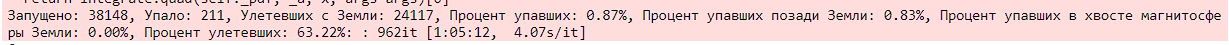

In [39]:
data = magn.make_Earth(data)
data = magn.make_torus(data)

In [ ]:
magn.plot_image(data)

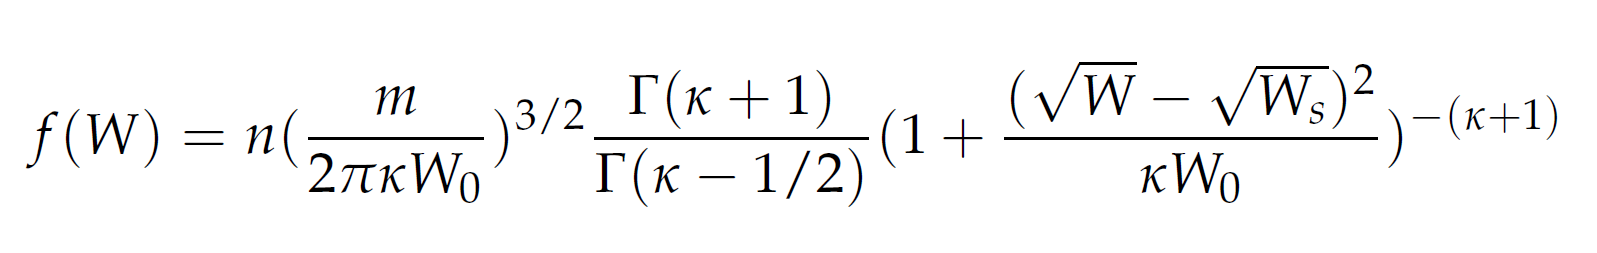

In [170]:
y = np.array([4e3, 3.8e3, 4.2e3, 8e3, 6e3, 7.9e3, 7.8e3, 9e3, 7e3, 5.9e3,
              3.5e3, 2.5e3, 2.1e3, 2e3, 1.8e3, 1.5e3, 1.3e3, 1.2e3, 1e3])
x = np.array([0.025, 0.045, 0.09, 0.22, 0.31, 0.4, 0.6,
             0.8, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [162]:
from scipy.optimize import curve_fit
from scipy.special import gamma

In [294]:
m_particles = 16*m
m_particles = m_particles*c**2 * 1e-3 / q
def func(w, w_0, n, k, w_shift):
    return n * (m_particles / (2*np.pi*k*w_0))**(3/2) * gamma(k+1) / gamma(k-0.5) / (1 + (np.sqrt(w) - np.sqrt(w_shift))**2 / (k*w_0))**(k+1)

In [365]:
popt, pcov = curve_fit(func, x, y,
                       bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]), method='trf')

In [366]:
popt

array([1.51956356, 9.32469851, 0.50000017, 0.67621311])

In [394]:

class W_dist(rv_continuous):
    def _pdf(self, w):
        return 1/3.516 * 1 / (1 + (np.sqrt(w) - 0.82)**2 / (0.76))**(1.5)
    
w_dist = W_dist(name='W_dist', a=0, b=np.inf)



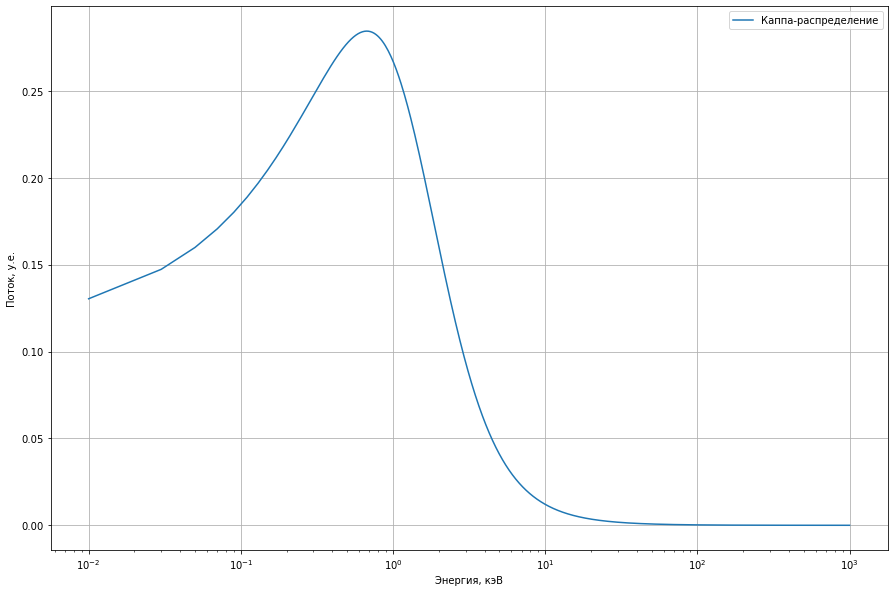

In [398]:
x_range = np.linspace(0.01, 1000, 50000)
plt.figure(figsize=(15, 10))
plt.plot(x_range, w_dist.pdf(x_range), label='Каппа-распределение')
# plt.plot(x, y, 'o', label='Точки со спутника')
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Поток, у.е.')
plt.xlabel('Энергия, кэВ')
plt.legend()
plt.grid();

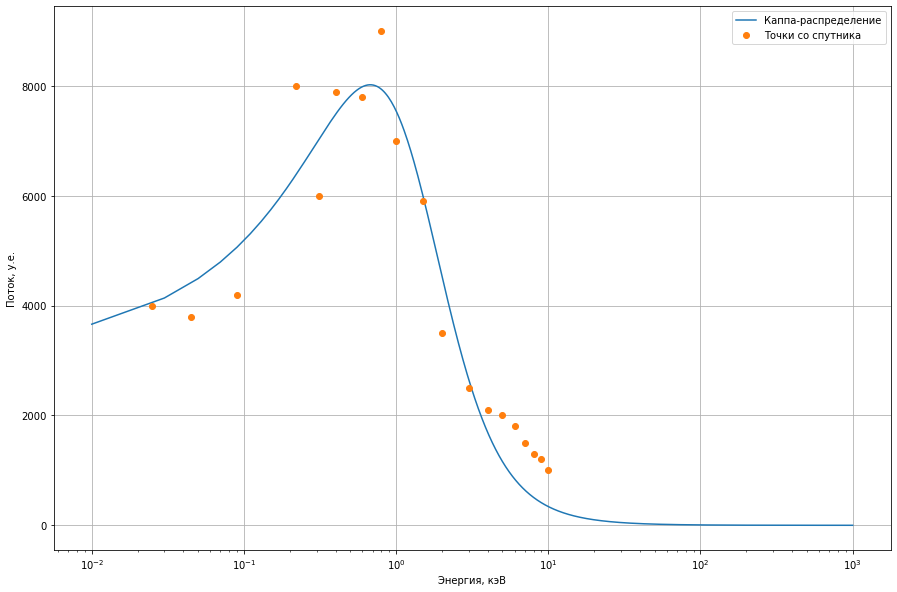

In [367]:
x_range = np.linspace(0.01, 1000, 50000)
plt.figure(figsize=(15, 10))
plt.plot(x_range, func(x_range, w_0, n, k, w_shift), label='Каппа-распределение')
plt.plot(x, y, 'o', label='Точки со спутника')
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Поток, у.е.')
plt.xlabel('Энергия, кэВ')
plt.legend()
plt.grid();